In [1]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [2]:
import ast # used for parsing string to list
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.base import clone
from utils.constants import SEED, TARGET, SPLIT_TYPE
from select_models import baseline_models, model_needs_scaling
from select_models import get_training_data
from stacked_ensemble import BearStackedEnsemble, RegimeStackedEnsemble
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
def load_data(stacked_model):
    model = stacked_model
    fs = model.get_feature_set()
        
    # get data
    data = get_training_data(fs['split_type'], fs['feature'], fs['target'])
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']

    # if TARGET == 'Regime':
    #     # print("Using SVMSMOTE to oversample the minority class on the training set\n")
    #     # sm = SMOTE(random_state=SEED)
    #     # sm = BorderlineSMOTE(random_state=SEED, kind='borderline-2')
    #     sm = SVMSMOTE(random_state=SEED)
    #     # sm = ADASYN(random_state=SEED)
    #     X_res, y_res = sm.fit_resample(X_train, y_train)
    #     X_train = X_res
    #     y_train = y_res

    return X_train, y_train.values.ravel(), X_test, y_test.values.ravel()

def get_ensemble_model(target=TARGET):
    if target == 'bear':
        return BearStackedEnsemble()
    if target == 'Regime':
        return RegimeStackedEnsemble()
    return None

In [4]:
def train_classifier(model, X_train, y_train):
    clf = model
    clf.fit(X_train, y_train)
    return clf

def create_correlation_matrix(X):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2  # Ensure the correlation matrix is symmetric
    np.fill_diagonal(corr, 1)
    return corr

def perform_hierarchical_clustering(corr, method='ward'):
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.linkage(squareform(distance_matrix), method=method)
    return dist_linkage

def plot_dendrogram(X, ax):
    corr = create_correlation_matrix(X)
    dist_linkage = perform_hierarchical_clustering(corr)
    dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax, leaf_rotation=90)
    return dendro

def plot_heatmap(corr, dendro, ax):
    ax.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax.set_xticks(np.arange(0, len(dendro["ivl"])))
    ax.set_yticks(np.arange(0, len(dendro["ivl"])))
    ax.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro["ivl"])

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

def select_features_by_cluster(X, dist_linkage, threshold=1):
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return X.columns[selected_features]

def filter_features_by_importance(X, perm_importance, threshold=0.005):
    """Returns the subset of features that have an importance mean above the threshold."""
    important_feature_indices = np.where(perm_importance.importances_mean >= threshold)[0]
    important_features = X.columns[important_feature_indices]
    return important_features


----------------------------------------------------
**Data is using the 'std' split type**
**Data is using the 'bear' target**

Davies–Bouldin Index: 1.0557397903966605


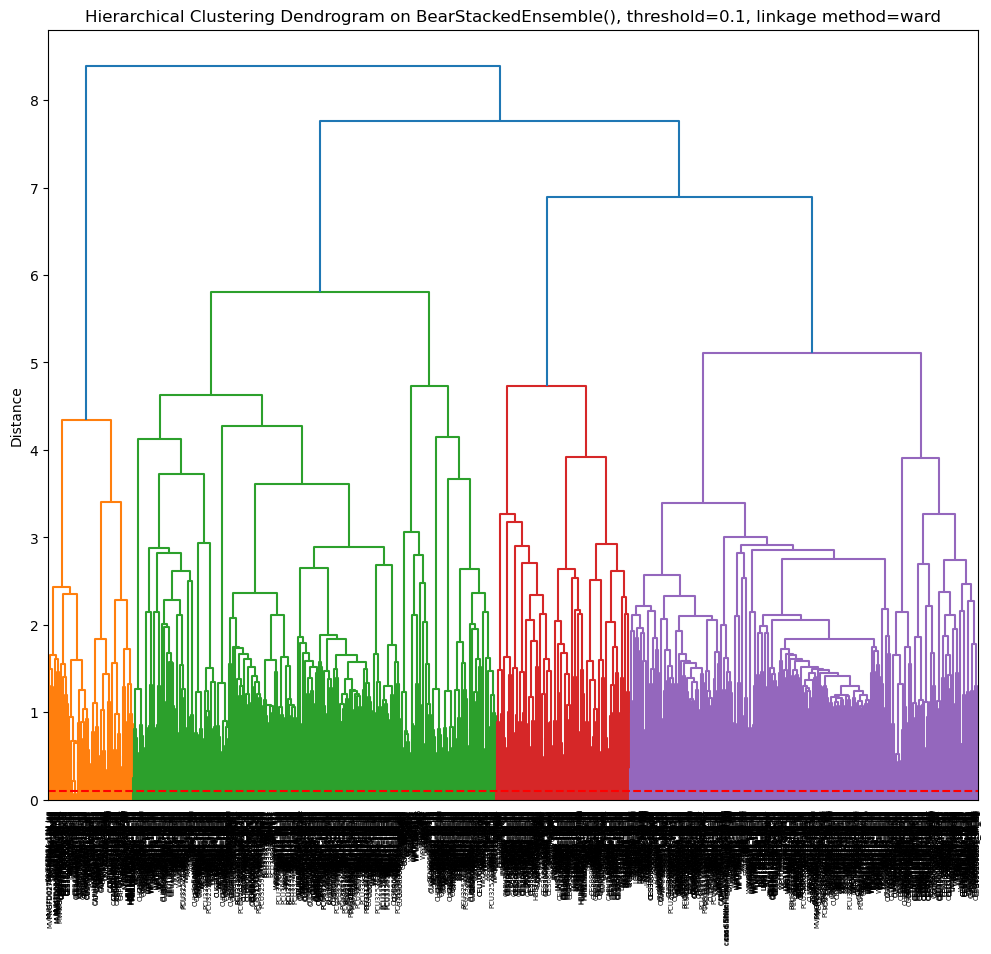

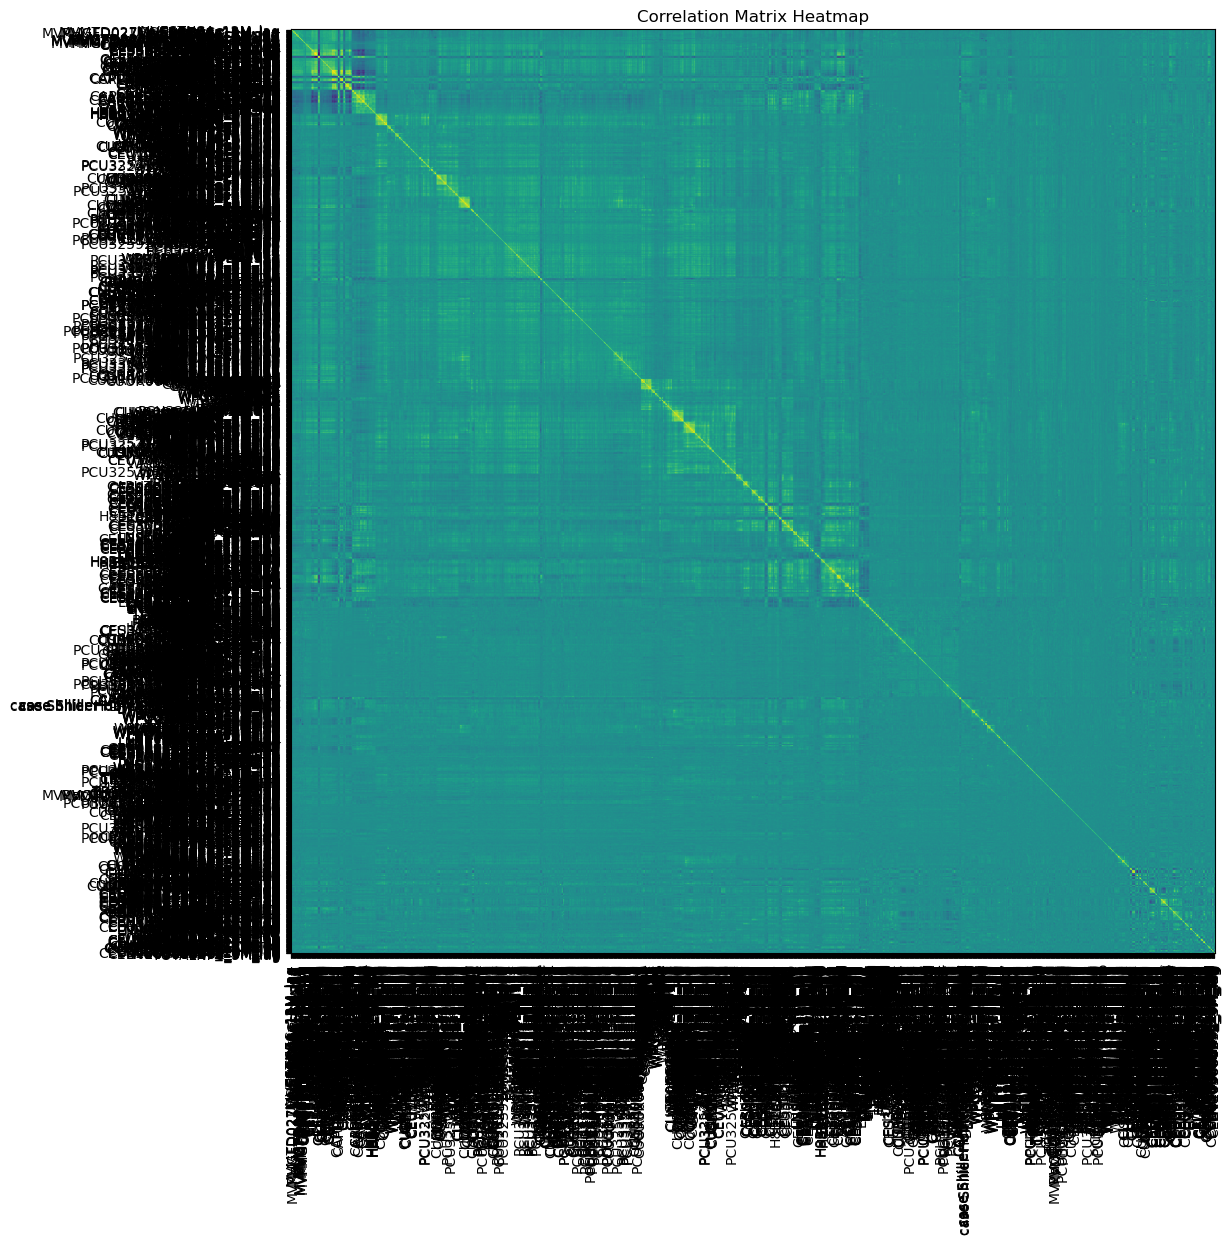

In [5]:
# Plot Dendrogram
from sklearn.metrics import davies_bouldin_score
X_train, y_train, X_test, y_test = load_data(get_ensemble_model())
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
METHOD = 'ward'

def get_thresh(target=TARGET):
    if target == 'bear':
        return 0.1
    return 1
threshold = get_thresh()
fig1, ax1 = plt.subplots(figsize=(12, 10))
dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X), method=METHOD)
dendro = plot_dendrogram(X, ax1)
# Assuming `dendro` is the result from `plot_dendrogram` that contains linkage matrix
# Convert dendrogram/ linkage matrix into flat clusters based on the threshold
clusters = hierarchy.fcluster(dist_linkage, t=threshold, criterion='distance')

# Transpose X to treat features as samples for DBI calculation
X_transposed = X.T

# Calculate Davies–Bouldin Index
db_index = davies_bouldin_score(X_transposed, clusters)

print(f"Davies–Bouldin Index: {db_index}")


plt.title(f'Hierarchical Clustering Dendrogram on {get_ensemble_model()}, threshold={threshold}, linkage method={METHOD}')
# plt.title(f'Hierarchical Clustering Dendrogram on All Features, threshold={threshold}')
ax1.set_ylabel('Distance')
# horizontal line at y=threshold
ax1.axhline(y=threshold, color='r', linestyle='--')
plt.show()

# Plot Heatmap
fig2, ax2 = plt.subplots(figsize=(22, 12))
corr = create_correlation_matrix(X)
plot_heatmap(corr, dendro, ax2)
plt.title(f'Correlation Matrix Heatmap')

plt.show()


In [6]:
def export_results(best_scores, best_features, filename='feature_selection_results.csv'):
    base_path = "feature_selection/"
    results_df = pd.DataFrame(best_scores.items(), columns=['model', 'best_score'])
    results_df['best_features'] = best_features.values()

    results_df = results_df.dropna()

    # tab separated file
    results_df.to_csv(base_path + filename, index=False, sep='\t')
    print(f"Results exported to {filename}")

    # Parse the 'best_features' column from string representation of a list to an actual list
    # results_df['best_features'] = results_df['best_features'].apply(ast.literal_eval)
    return results_df

def calculate_permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1):
    result = permutation_importance(clf, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs)
    return result

def get_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions, average='macro', zero_division=0),
        'recall': recall_score(y_test, predictions, average='macro'),
        'f1_score': f1_score(y_test, predictions, average='macro'),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    return metrics

def scale_data(X_train, X_test=None):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) if X_test is not None else None
    
    # Convert scaled arrays back to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns) if X_test is not None else None
    
    return X_train_scaled_df, X_test_scaled_df

def optimize_and_evaluate(models, stacked_model, target_types=[TARGET], split_types=[SPLIT_TYPE], threshold=0.25, n_iterations=5):
    """
    Optimizes models using permutation importance feature selection and evaluates them.
    Optionally visualizes the permutation importance results.
    Returns the best scores and features for each model.
    """
    print(f"\nFinding best features for {len(models)} models on {len(target_types)} target(s) and {len(split_types)} split(s)...")

    best_scores = {}
    best_features = {}

    # Create a figure for the subplots
    fig, axes = plt.subplots(figsize=(7,4))

    # Counter for the current subplot index
    subplot_idx = 0
    
    for target in target_types:
        
        for split in split_types:
            X_train, y_train, X_test, y_test = load_data(stacked_model)
            X_full = pd.concat([X_train, X_test])

            for model in models:
                model_name = type(model).__name__
                # print(f"Evaluating {model_name} on target: {target}, split: {split}")

                # Check if the model requires data scaling
                if model_name in model_needs_scaling:
                    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
                    # Use scaled data for training and testing
                    X_train_use, X_test_use = X_train_scaled, X_test_scaled
                else:
                    # Use original data for models that don't require scaling
                    X_train_use, X_test_use = X_train, X_test

                best_model_score = 0
                best_iteration_features = None
                
                # Initial Feature Selection
                dist_linkage = perform_hierarchical_clustering(create_correlation_matrix(X_full))
                threshold = threshold
                selected_feature_names = select_features_by_cluster(X_full, dist_linkage, threshold=threshold)
                print(f"Initial selected features count: {len(selected_feature_names)}")

                for iteration in range(1, n_iterations + 1):
                    X_train_sel = X_train_use[selected_feature_names]
                    X_test_sel = X_test_use[selected_feature_names]

                    clf_sel = train_classifier(model, X_train_sel, y_train)
                    metrics = get_metrics(clf_sel, X_test_sel, y_test)

                    average_score = np.mean([metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['roc_auc']])

                    print(f"Iteration {iteration} average score: {average_score}")

                    perm_importance = calculate_permutation_importance(clf_sel, X_test_sel, y_test)
                    important_features = filter_features_by_importance(X_test_sel, perm_importance)
                    print(f"Iteration {iteration} important features: {len(important_features)}")

                    if len(important_features) == 0:
                        break

                    # Update for next iteration or final selection
                    selected_feature_names = important_features
                    if average_score > best_model_score:
                        best_model_score = average_score  # Update with the average score
                        best_iteration_features = important_features

                best_scores[model_name] = best_model_score
                best_features[model_name] = list(best_iteration_features) if best_iteration_features is not None else None

                if best_iteration_features is not None:
                    # Use the next subplot for the current model
                    ax = axes
                    plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
                    best_score_rounded = round(best_model_score, 4)  # Round the best score to 3 significant figures
                    ax.set_title(f"{model_name} - Best Score: {best_score_rounded}")
                    ax.set_xlabel("Decrease in average scores")
                    subplot_idx += 1  # Increment the subplot index

            title_string = f"Permutation Importance for {target} Stage 2 Ensemble Model"

            fig.suptitle(title_string)
            plt.tight_layout()
            plt.show()
            filename = f"permutation_importance_{target}_{split}_stacked.csv"

            df = export_results(best_scores, best_features, filename=filename)

    return df


Finding best features for 1 models on 1 target(s) and 1 split(s)...

----------------------------------------------------
**Data is using the 'std' split type**
**Data is using the 'bear' target**

Initial selected features count: 2280
Iteration 1 average score: 0.7465427854710149
Iteration 1 important features: 256
Iteration 2 average score: 0.9349029508921373
Iteration 2 important features: 27
Iteration 3 average score: 0.9769712977170556
Iteration 3 important features: 16
Iteration 4 average score: 0.9861333824883175
Iteration 4 important features: 9
Iteration 5 average score: 0.9812125160748867
Iteration 5 important features: 8


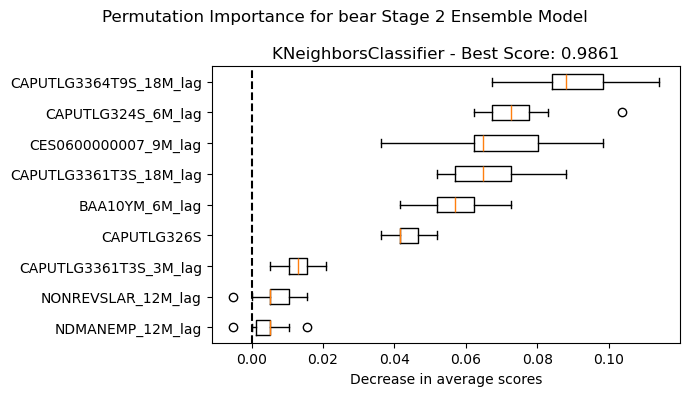

Results exported to permutation_importance_bear_std_stacked.csv


In [7]:
model = get_ensemble_model()
stage2_model = model.__initialize_stage2_model__()
results_df = optimize_and_evaluate([stage2_model], model, threshold=get_thresh())

In [8]:
results_df

,model,best_score,best_features
0,KNeighborsClassifier,0.986133,"[CAPUTLG326S, NDMANEMP_12M_lag, CES0600000007_..."



----------------------------------------------------
**Data is using the 'std' split type**
**Data is using the 'bear' target**


----------------------------------------------------
**Data is using the 'std' split type**
**Data is using the 'bear' target**

No best features found for LogisticRegression, skipping.


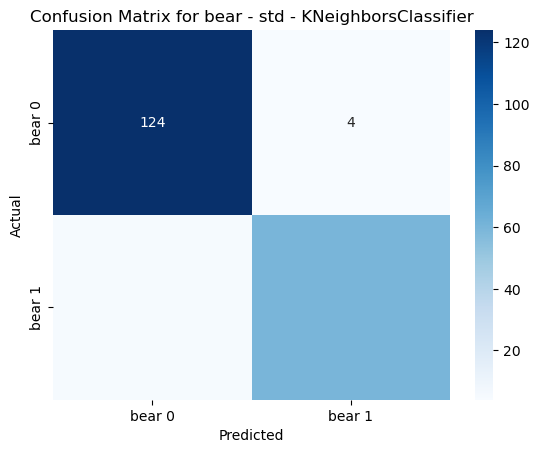

No best features found for SVC, skipping.
No best features found for GaussianNB, skipping.
No best features found for BernoulliNB, skipping.
No best features found for GaussianProcessClassifier, skipping.
No best features found for DecisionTreeClassifier, skipping.
No best features found for RandomForestClassifier, skipping.
No best features found for GradientBoostingClassifier, skipping.
No best features found for AdaBoostClassifier, skipping.
No best features found for ExtraTreesClassifier, skipping.
No best features found for BaggingClassifier, skipping.
No best features found for XGBClassifier, skipping.


,recall,roc_auc,accuracy,precision,f1
KNeighborsClassifier,0.9459,0.991,0.9534,0.9494,0.9476


In [9]:
def load_and_parse_results(target=TARGET, split=SPLIT_TYPE):
    filename = f'feature_selection/permutation_importance_{target}_{split}_stacked.csv'
    results_df = pd.read_csv(filename, sep='\t')
    # drop na
    results_df = results_df.dropna()
    # Parse the 'best_features' column from string representation of a list to an actual list
    results_df['best_features'] = results_df['best_features'].apply(ast.literal_eval)
    return results_df

def train_and_evaluate(model, X_train, y_train, X_test, y_test, target=TARGET, split=SPLIT_TYPE):
    """
    Helper function to train and evaluate a model on the test set. 
    Returns a dictionary of evaluation metrics.
    """
    model = clone(model)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    Y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "recall": recall_score(y_test, Y_pred, average='macro'),
        "roc_auc": roc_auc_score(y_test, Y_pred_proba) if hasattr(model, "predict_proba") else None,
        "accuracy": accuracy_score(y_test, Y_pred),
        "precision": precision_score(y_test, Y_pred, average='macro'),
        "f1": f1_score(y_test, Y_pred, average='macro'),
    }

    cm = confusion_matrix(y_test, Y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'{target} 0', f'{target} 1'], yticklabels=[f'{target} 0', f'{target} 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {target} - {split} - {model.__class__.__name__}')
    plt.show()

    results = {metric_name: round(metric_func, 4) for metric_name, metric_func in metrics.items()}
    return results

def get_evaluation(results_df):
    """
    Evaluate the models using the best features found from the feature selection process.
    Returns a DataFrame with the evaluation results.
    """
    evaluation_results = []

    models = baseline_models
    X_train, y_train, X_test, y_test = load_data(get_ensemble_model())

    for model in models:
        model_name = model.__class__.__name__
        # Ensure best_features is a flat list of feature names
        best_features_series = results_df.loc[results_df['model'] == model_name, 'best_features']
        if not best_features_series.empty:
            best_features = best_features_series.iloc[0]  # Access the first item if Series is not empty

            # Subset the datasets with the best features
            X_train_best = X_train[best_features].copy()
            X_test_best = X_test[best_features].copy()

            # Check if model needs scaling
            if model_name in model_needs_scaling:
                X_train_best, X_test_best = scale_data(X_train_best, X_test_best)

            # Evaluate the model using the best features
            metrics = train_and_evaluate(model, X_train_best, y_train, X_test_best, y_test)
            evaluation_results.append([model_name] + list(metrics.values()))
        else:
            print(f"No best features found for {model_name}, skipping.")

    # Convert the evaluation results into a DataFrame
    if evaluation_results:
        # Directly use the metric names from the dictionary used in `train_and_evaluate`
        metric_names = ['model'] + list(metrics.keys())  # Use metrics from the last iteration
        evaluation_df = pd.DataFrame(evaluation_results, columns=metric_names)
    else:
        evaluation_df = pd.DataFrame(columns=['model'] + list(metrics.keys()))

    # set the model name as the index
    evaluation_df = evaluation_df.set_index('model')
    evaluation_df.index.name = None

    # sort by recall
    evaluation_df = evaluation_df.sort_values(by='recall', ascending=False)
    return evaluation_df

model = get_ensemble_model()

X_train, y_train, X_test, y_test = load_data(model)
results_df = load_and_parse_results()
eval_df = get_evaluation(results_df)
eval_df

In [10]:
from sklearn.model_selection import StratifiedKFold

def load_prob_data():
    X_train = pd.read_csv(f'{TARGET}_train_probs.csv')
    X_test = pd.read_csv(f'{TARGET}_test_probs.csv')

    return X_train, X_test

def perform_cross_validation2(datatype, stacked_model, target=TARGET, split=SPLIT_TYPE):
    print(f"Performing 10-fold stratified cross-validation on {datatype} data for {target} - {split}.")
    cv_results = []
    precision_scorer = make_scorer(precision_score, zero_division=0)
    f1_scorer = make_scorer(f1_score, zero_division=0)

    scoring_metrics = {
        'recall': 'recall',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        # Use the custom scorers for metrics that need zero_division handling
        'precision': precision_scorer,
        'f1': f1_scorer
    }
    stage2_model = stacked_model.__initialize_stage2_model__()

    X_train, y_train, X_test, y_test = load_data(stacked_model)
    X_train, X_test = load_prob_data()

    if datatype=='train':
        X = X_train
        y = y_train
    
    if datatype=='test':
        X = X_test
        y = y_test

    stratified_cv = StratifiedKFold(
        n_splits=10, shuffle=True, random_state=SEED
    )

    model_name = type(stage2_model).__name__

    # check if model needs scaling
    if model_name in model_needs_scaling:
        X, _ = scale_data(X)

    # Prepare a dictionary to hold all scores for this model
    model_scores = {'model': model_name}

    for metric, scorer in scoring_metrics.items():
        # Perform cross-validation
        cv_scores = cross_val_score(stage2_model, X, y, cv=stratified_cv, scoring=scorer)
        
        # Update the dictionary with the mean and std of cv scores
        model_scores[f'mean_{metric}'] = round(cv_scores.mean(), 4)
        model_scores[f'std_{metric}'] = round(cv_scores.std(), 4)

    # Append the dictionary to cv_results after processing all metrics
    cv_results.append(model_scores)

    # Convert results to DataFrame
    df = pd.DataFrame(cv_results)
    df.set_index('model', inplace=True)
    df.index.name = None

    print(df)
    return df

In [11]:
cv_results = perform_cross_validation2(datatype='test', stacked_model=get_ensemble_model())

Performing 10-fold stratified cross-validation on test data for bear - std.

----------------------------------------------------
**Data is using the 'std' split type**
**Data is using the 'bear' target**

                      mean_recall  std_recall  mean_roc_auc  std_roc_auc  \
KNeighborsClassifier       0.9548      0.0694        0.9923       0.0213   

                      mean_accuracy  std_accuracy  mean_precision  \
KNeighborsClassifier         0.9847        0.0233             1.0   

                      std_precision  mean_f1  std_f1  
KNeighborsClassifier            0.0   0.9755  0.0376  


In [12]:
cv_results

,mean_recall,std_recall,mean_roc_auc,std_roc_auc,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_f1,std_f1
KNeighborsClassifier,0.9548,0.0694,0.9923,0.0213,0.9847,0.0233,1.0,0.0,0.9755,0.0376


In [ ]:
from sklearn.model_selection import StratifiedKFold

def load_prob_data():
    X_train = pd.read_csv(f'{TARGET}_train_probs.csv')
    X_test = pd.read_csv(f'{TARGET}_test_probs.csv')

    return X_train, X_test

def perform_cross_validation2(datatype, stacked_model, target=TARGET, split=SPLIT_TYPE):
    print(f"Performing 10-fold stratified cross-validation on {datatype} data for {target} - {split}.")
    cv_results = []
    precision_scorer = make_scorer(precision_score, zero_division=0)
    f1_scorer = make_scorer(f1_score, zero_division=0)

    scoring_metrics = {
        'recall': 'recall',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        # Use the custom scorers for metrics that need zero_division handling
        'precision': precision_scorer,
        'f1': f1_scorer
    }
    stage2_model = stacked_model.__initialize_stage2_model__()

    X_train, y_train, X_test, y_test = load_data(stacked_model)
    X_train, X_test = load_prob_data()

    if datatype=='train':
        X = X_train
        y = y_train
    
    if datatype=='test':
        X = X_test
        y = y_test

    stratified_cv = StratifiedKFold(
        n_splits=10, shuffle=True, random_state=SEED
    )

    model_name = type(stage2_model).__name__

    # check if model needs scaling
    if model_name in model_needs_scaling:
        X, _ = scale_data(X)

    # Prepare a dictionary to hold all scores for this model
    model_scores = {'model': model_name}

    for metric, scorer in scoring_metrics.items():
        # Perform cross-validation
        cv_scores = cross_val_score(stage2_model, X, y, cv=stratified_cv, scoring=scorer)
        
        # Update the dictionary with the mean and std of cv scores
        model_scores[f'mean_{metric}'] = round(cv_scores.mean(), 4)
        model_scores[f'std_{metric}'] = round(cv_scores.std(), 4)

    # Append the dictionary to cv_results after processing all metrics
    cv_results.append(model_scores)

    # Convert results to DataFrame
    df = pd.DataFrame(cv_results)
    df.set_index('model', inplace=True)
    df.index.name = None

    print(df)
    return df